# 🏠 房屋價格探索性資料分析 (EDA)

**專案目標：** 對 Kaggle 房屋價格資料集進行完整探索性分析  
**資料來源：** [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)  
**分析重點：** 了解資料分布、找出重要特徵、檢測資料問題、為特徵工程做準備

In [1]:
# Cell 1: Import all necessary packages
import sys
import os
sys.path.append('../src')

# Import Python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from utils import setup_environment
from data_loader import load_dataset, get_data_info
from data_cleaner import check_missing_data, remove_high_missing_columns
from visualization import plot_price_distribution, plot_correlation_analysis
from feature_engineering import create_new_features, apply_log_transform
from utils import detect_outliers_iqr
from pdf_report import create_pdf_report

# Setup environment
setup_environment()
print("✅ All packages and modules loaded successfully!")

✅ Environment setup completed
✅ All packages and modules loaded successfully!


In [2]:
# Cell 2: Load data
train, test = load_dataset('../data')
get_data_info(train, test)

# Display first few rows
print("\n📋 Data preview:")
train.head(3)

✅ Datasets loaded successfully
📊 Dataset Information:
Training set shape: (1460, 81)
Test set shape: (1459, 80)
Training features: 81
Test features: 80
Target variable range: $34,900 - $755,000

📋 Data preview:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
# Cell 3: Basic information
print("📊 Basic statistics:")
train.describe()

print(f"\n📝 Data types:")
train.info()

📊 Basic statistics:

📝 Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    14

🎯 Target variable analysis


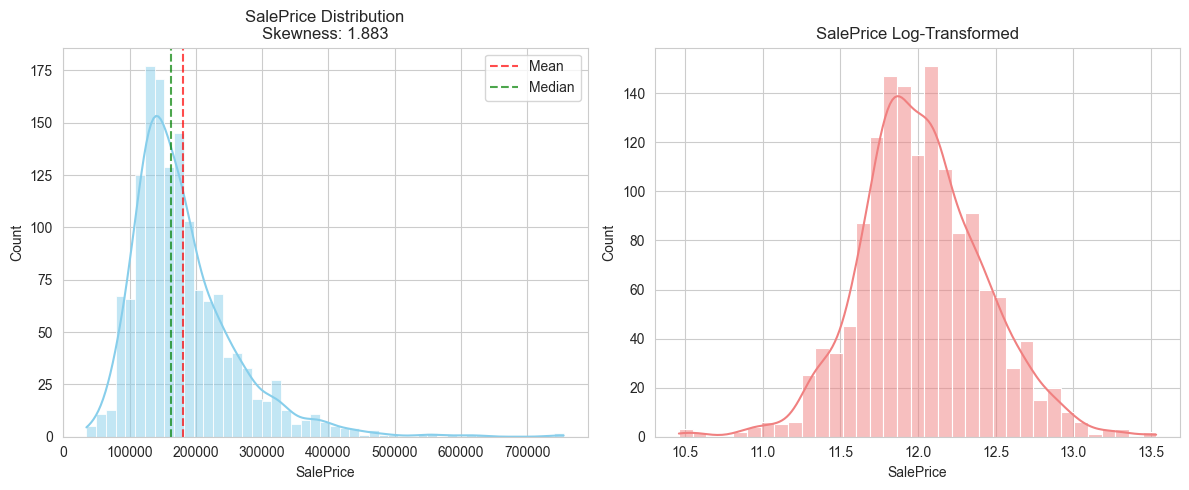

Mean: $180,921
Median: $163,000
Standard deviation: $79,443
Skewness: 1.883


In [4]:
# Cell 4: Target variable analysis
print("🎯 Target variable analysis")

if 'SalePrice' in train.columns:
    fig = plot_price_distribution(train)
    plt.show()

    sp_stats = train['SalePrice'].describe()
    print(f"Mean: ${sp_stats['mean']:,.0f}")
    print(f"Median: ${sp_stats['50%']:,.0f}")
    print(f"Standard deviation: ${sp_stats['std']:,.0f}")
    print(f"Skewness: {train['SalePrice'].skew():.3f}")

In [5]:
# Cell 5: Missing values analysis
print("🔍 Missing values analysis")

missing_report = check_missing_data(train, show_top=10)
train_clean = remove_high_missing_columns(train, threshold=80)
print(f"Cleaned data shape: {train_clean.shape}")

🔍 Missing values analysis
🔍 Missing Values Analysis:
Columns with missing values: 19
Total missing values: 7829

Top 10 columns with most missing values:


,Missing_Count,Missing_Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
MasVnrType,872,59.73
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55


🗑️ Removing 4 columns with > 80% missing:
  - Alley: 93.8%
  - PoolQC: 99.5%
  - Fence: 80.8%
  - MiscFeature: 96.3%
Cleaned data shape: (1460, 77)
Cleaned data shape: (1460, 77)


📈 Correlation analysis


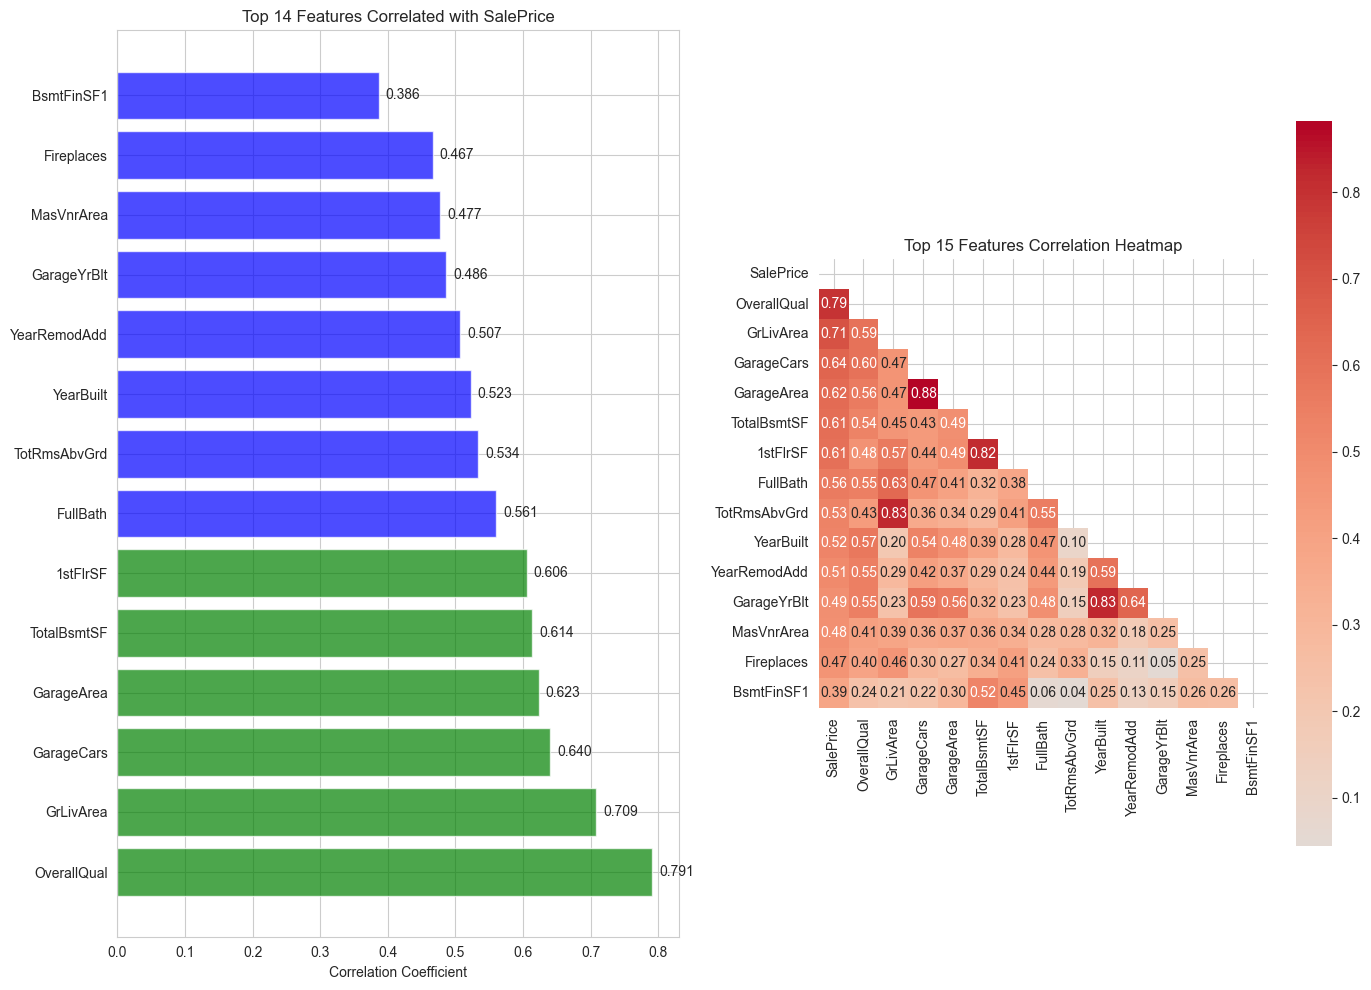

🏆 Top correlated features:


,Feature,Correlation
0,SalePrice,1.000000
1,OverallQual,0.790982
2,GrLivArea,0.708624
3,GarageCars,0.640409
4,GarageArea,0.623431
5,TotalBsmtSF,0.613581
6,1stFlrSF,0.605852
7,FullBath,0.560664
8,TotRmsAbvGrd,0.533723
9,YearBuilt,0.522897


In [6]:
# Cell 6: Correlation analysis
print("📈 Correlation analysis")

if train_clean is not None and 'SalePrice' in train_clean.columns:
    fig, corr_df = plot_correlation_analysis(train_clean, top_n=15)
    plt.show()

    print("🏆 Top correlated features:")
    display(corr_df.head(10))

In [7]:
# Cell 7: Outlier detection
print("🚨 Outlier detection")

important_features = ['GrLivArea', 'TotalBsmtSF', 'LotArea']
for feature in important_features:
    if feature in train_clean.columns:
        outliers = detect_outliers_iqr(train_clean, feature)
        if len(outliers) > 0:
            print(f"{feature} outlier examples:")
            display(outliers[[feature, 'SalePrice']].head(2))

🚨 Outlier detection
📊 Outlier detection for GrLivArea:
  Normal range: 158.62 - 2747.62
  Outliers count: 31
GrLivArea outlier examples:


,GrLivArea,SalePrice
58,2945,438780
118,3222,320000


📊 Outlier detection for TotalBsmtSF:
  Normal range: 42.00 - 2052.00
  Outliers count: 61
TotalBsmtSF outlier examples:


,TotalBsmtSF,SalePrice
17,0,90000
39,0,82000


📊 Outlier detection for LotArea:
  Normal range: 1481.50 - 17673.50
  Outliers count: 69
LotArea outlier examples:


,LotArea,SalePrice
53,50271,385000
66,19900,180000


In [8]:
# Cell 8: Feature engineering
print("🛠️ Feature engineering")

train_with_features = create_new_features(train_clean)
print(f"Data shape after feature engineering: {train_with_features.shape}")

columns_to_transform = ['SalePrice', 'GrLivArea', 'LotArea']
train_transformed = apply_log_transform(train_with_features, columns_to_transform)

new_feature_cols = [col for col in train_transformed.columns if col not in train_clean.columns]
print(f"New features created: {new_feature_cols}")

🛠️ Feature engineering
✅ New feature: HouseAge
✅ New feature: TotalArea
✅ New feature: HasPool
✅ New feature: TotalBath
Data shape after feature engineering: (1460, 81)
✅ Log transform: SalePrice → log_SalePrice
✅ Log transform: GrLivArea → log_GrLivArea
✅ Log transform: LotArea → log_LotArea
New features created: ['HouseAge', 'TotalArea', 'HasPool', 'TotalBath', 'log_SalePrice', 'log_GrLivArea', 'log_LotArea']


🏘️ Categorical features analysis


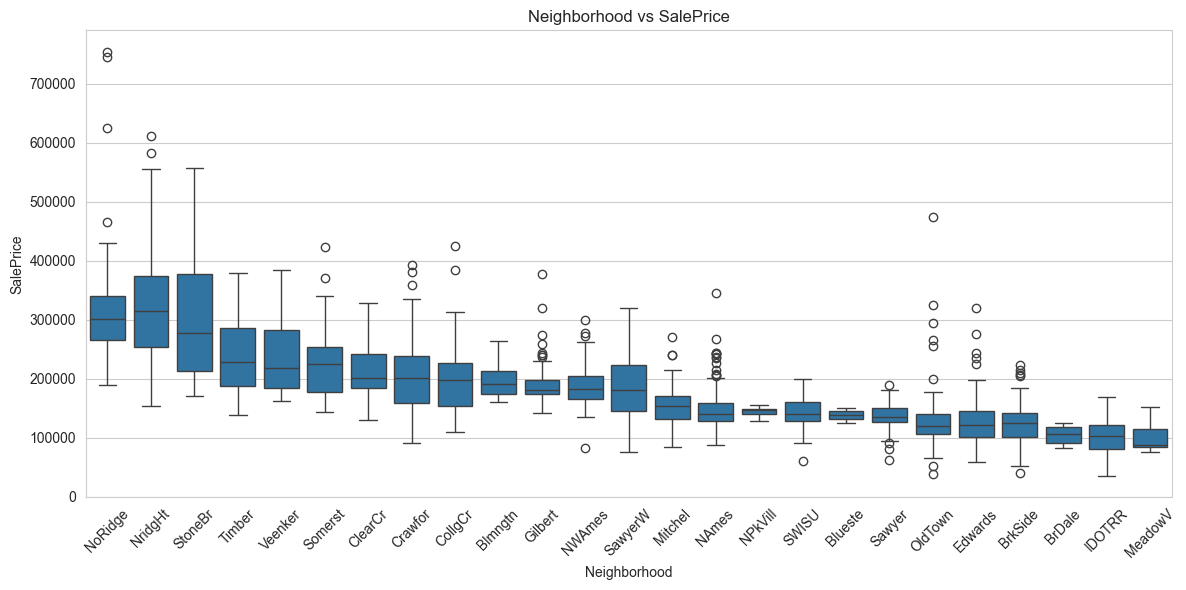

Neighborhood: 25 categories


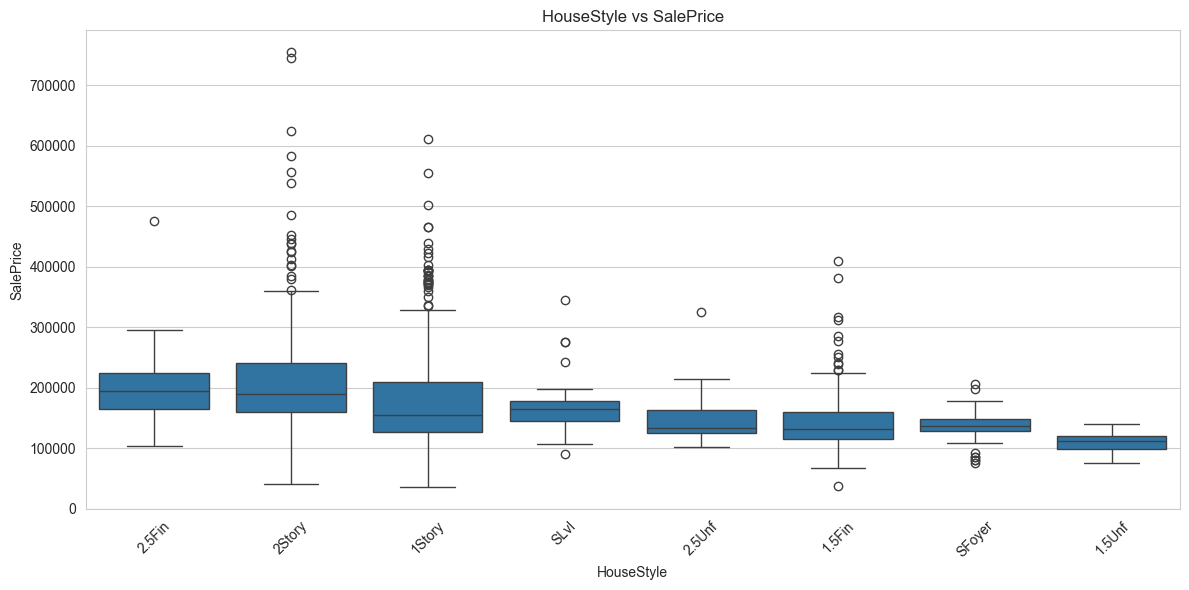

HouseStyle: 8 categories


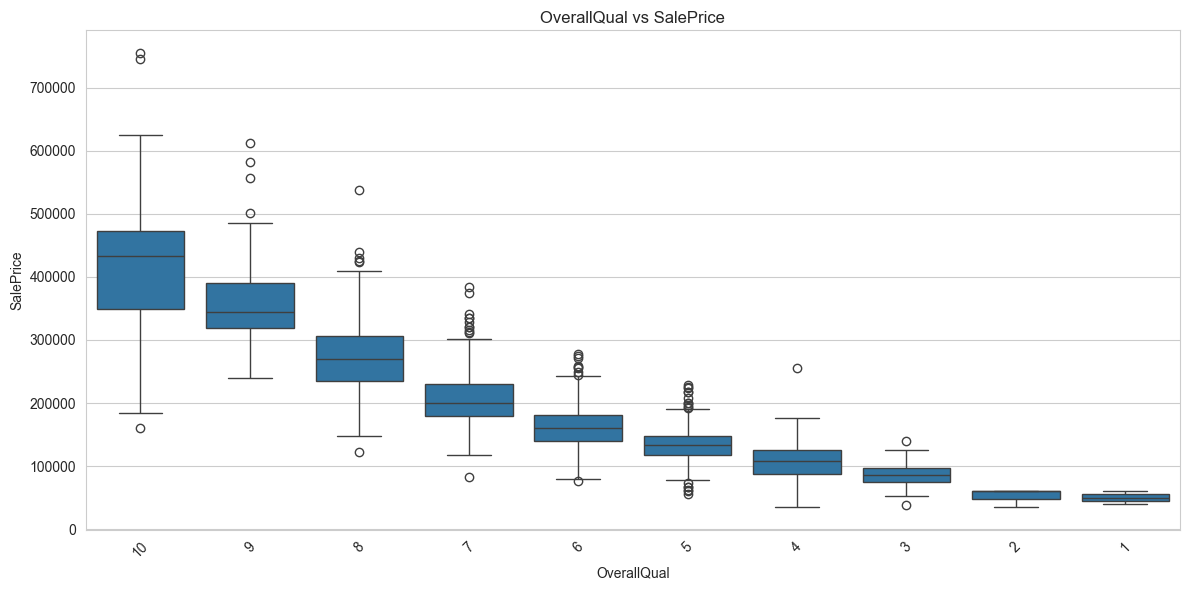

OverallQual: 10 categories


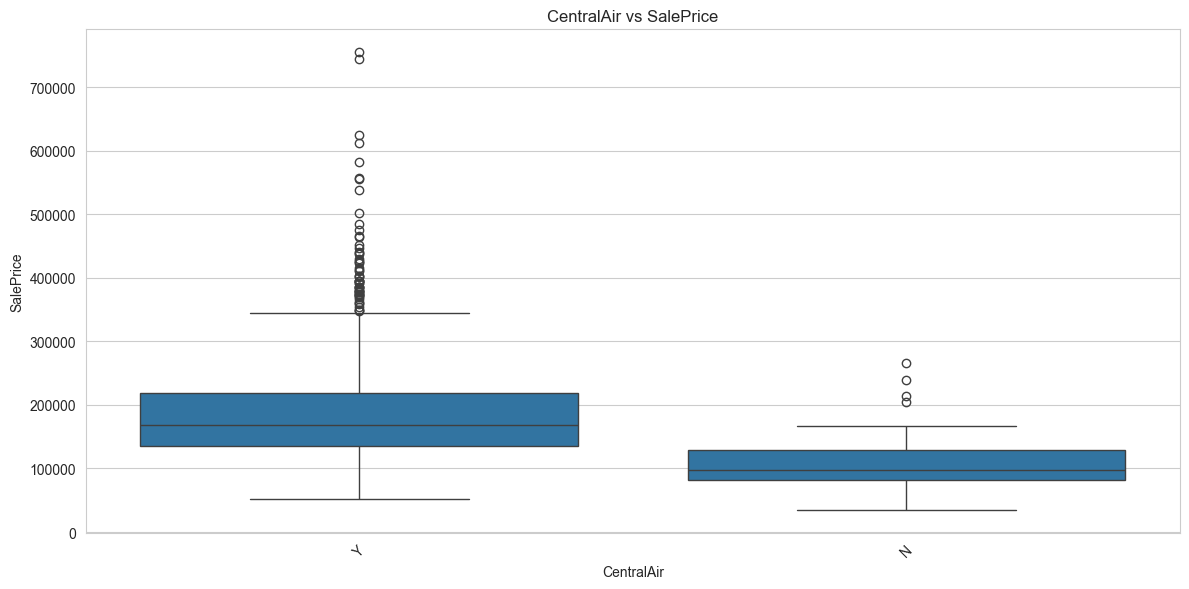

CentralAir: 2 categories


In [9]:
# Cell 9: Categorical features analysis
print("🏘️ Categorical features analysis")

categorical_features = ['Neighborhood', 'HouseStyle', 'OverallQual', 'CentralAir']

for feature in categorical_features:
    if feature in train_transformed.columns:
        if train_transformed[feature].dtype == 'object' or train_transformed[feature].nunique() < 15:
            plt.figure(figsize=(12, 6))
            
            if 'SalePrice' in train_transformed.columns:
                mean_prices = train_transformed.groupby(feature)['SalePrice'].mean().sort_values(ascending=False)
                
                sns.boxplot(data=train_transformed, x=feature, y='SalePrice', order=mean_prices.index)
                plt.xticks(rotation=45)
                plt.title(f'{feature} vs SalePrice')
                plt.tight_layout()
                plt.show()
                
                print(f"{feature}: {train_transformed[feature].nunique()} categories")

In [10]:
# Cell 10: Generate PDF report
print("📄 Generating PDF report")

try:
    report_data = {
        'train_df': train,
        'corr_df': corr_df if 'corr_df' in locals() else None,
        'missing_df': missing_report if 'missing_report' in locals() else None,
        'new_features': new_feature_cols if 'new_feature_cols' in locals() else None
    }
    
    pdf_path = create_pdf_report(**report_data)
    print(f"🎉 PDF report successfully generated: {pdf_path}")
    
except Exception as e:
    print(f"❌ Error generating PDF: {e}")
    import traceback
    traceback.print_exc()

📄 Generating PDF report
✅ PDF report generated: ../reports/eda_report.pdf
🎉 PDF report successfully generated: ../reports/eda_report.pdf


In [13]:
# Cell 11: Summary report
print("=" * 60)
print("EDA SUMMARY REPORT")
print("=" * 60)

summary = {
    "Data Quality": [
        f"Original data: {train.shape}",
        f"Cleaned data: {train_clean.shape}",
        f"Columns with missing values: {len(missing_report)}",
        f"Columns removed: {train.shape[1] - train_clean.shape[1]}"
    ],
    "Target Variable": [
        f"Price range: ${train['SalePrice'].min():,} - ${train['SalePrice'].max():,}",
        f"Skewness: {train['SalePrice'].skew():.3f}",
        "Recommendation: Log transformation"
    ],
    "Key Findings": [
        f"Most correlated feature: {corr_df.iloc[1]['Feature']} ({corr_df.iloc[1]['Correlation']:.3f})" if 'corr_df' in locals() else "Correlation: Not analyzed",
        f"Strong correlated features (>0.5): {len(corr_df[corr_df['Correlation'] > 0.5])}" if 'corr_df' in locals() else "",
        f"New features created: {len(new_feature_cols)}" if 'new_feature_cols' in locals() else ""
    ],
    "Next Steps": [
        "Advanced feature engineering",
        "Handle categorical variables encoding", 
        "Build predictive models",
        "Model evaluation and optimization"
    ]
}

for category, items in summary.items():
    print(f"\n{category}:")
    for item in items:
        if item:  # Only print non-empty items
            print(f"  • {item}")

print("\n" + "=" * 60)
print("EDA analysis completed successfully!")
print("=" * 60)

EDA SUMMARY REPORT

Data Quality:
  • Original data: (1460, 81)
  • Cleaned data: (1460, 77)
  • Columns with missing values: 19
  • Columns removed: 4

Target Variable:
  • Price range: $34,900 - $755,000
  • Skewness: 1.883
  • Recommendation: Log transformation

Key Findings:
  • Most correlated feature: OverallQual (0.791)
  • Strong correlated features (>0.5): 11
  • New features created: 7

Next Steps:
  • Advanced feature engineering
  • Handle categorical variables encoding
  • Build predictive models
  • Model evaluation and optimization

EDA analysis completed successfully!
